<a href="https://colab.research.google.com/github/Mhmd-sh3rawy/Spotify_dataset_NTI/blob/main/RFspotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [2]:
%pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import learning_curve

In [4]:
# Load the dataset
df = pd.read_csv('Spotify-dataset.csv', low_memory=False)

In [5]:
df.head()

,index,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [6]:
df.shape

(114000, 21)

# Preprocessing

In [7]:
# Drop unnecessary columns
df = df.drop(['index', 'track_id', 'album_name'], axis=1)

# Handle missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

In [8]:
# Convert track_name and artists to lowercase
df['artists'] = df['artists'].str.lower()
df['track_name'] = df['track_name'].str.lower()

# Convert duration_ms to minutes
df['duration_ms'] = df['duration_ms'] / (1000 * 60)
df.rename(columns={'duration_ms': 'duration_min'}, inplace=True)

# Remove rows with zero popularity
old = df.shape[0]
df = df[df['popularity'] >= 1]
print(f"Removed {old - df.shape[0]} rows with zero popularity")

Removed 9799 rows with zero popularity


In [9]:
# Relation betwwen Genres and Popularity
df.groupby(['track_genre'])['popularity'].mean().sort_values(ascending=False)

,popularity
track_genre,
pop,60.678161
pop-film,59.399198
k-pop,59.279458
electro,59.110016
house,58.364103
...,...
grindcore,14.673367
chicago-house,12.392137
detroit-techno,11.213280


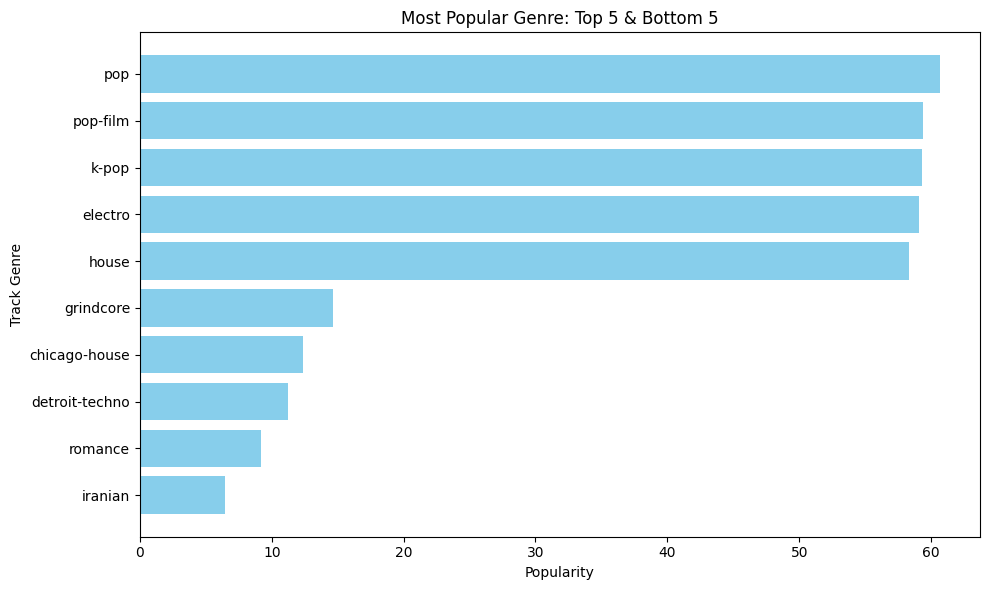

In [10]:
summary_df = df.groupby(['track_genre'])['popularity'].mean().sort_values(ascending=False)

plot_df = pd.concat([summary_df.head(5), summary_df.tail(5)])

plt.figure(figsize=(10, 6))
plt.barh(plot_df.index, plot_df.values, color='skyblue')
plt.xlabel('Popularity')
plt.ylabel('Track Genre')
plt.title('Most Popular Genre: Top 5 & Bottom 5')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
# Convert explicit to binary
df['explicit'] = df['explicit'].map({False: 0, True: 1})

# Frequency encoding for artists (high cardinality)
artist_freq = df['artists'].value_counts().to_dict()
df['artist_freq'] = df['artists'].map(artist_freq)
df = df.drop('artists', axis=1)

# Target encoding for track_name (high cardinality)
encoder = TargetEncoder(cols=['track_name'])
df['track_name_encoded'] = encoder.fit_transform(df['track_name'], df['popularity'])
df = df.drop('track_name', axis=1)

# Bin popularity into categories
bins = [0, 20, 40, 60, 80, 100]
labels = ['Low', 'Normal', 'Medium', 'High', 'Very High']
df['popularity'] = pd.cut(df['popularity'], bins=bins, labels=labels, include_lowest=True)
print("\nPopularity bin distribution:")
print(df['popularity'].value_counts().sort_index())


Popularity bin distribution:
popularity
Low          17474
Normal       33067
Medium       33061
High         12595
Very High      952
Name: count, dtype: int64


In [12]:
# Convert binary features using mean threshold
df['instrumentalness'] = (df['instrumentalness'] > df['instrumentalness'].mean()).astype(int)
df['liveness'] = (df['liveness'] > df['liveness'].mean()).astype(int)


In [13]:
# Cap outliers for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in numerical_cols:
    df[col] = np.where(df[col] < lower_bound[col], lower_bound[col], df[col])
    df[col] = np.where(df[col] > upper_bound[col], upper_bound[col], df[col])


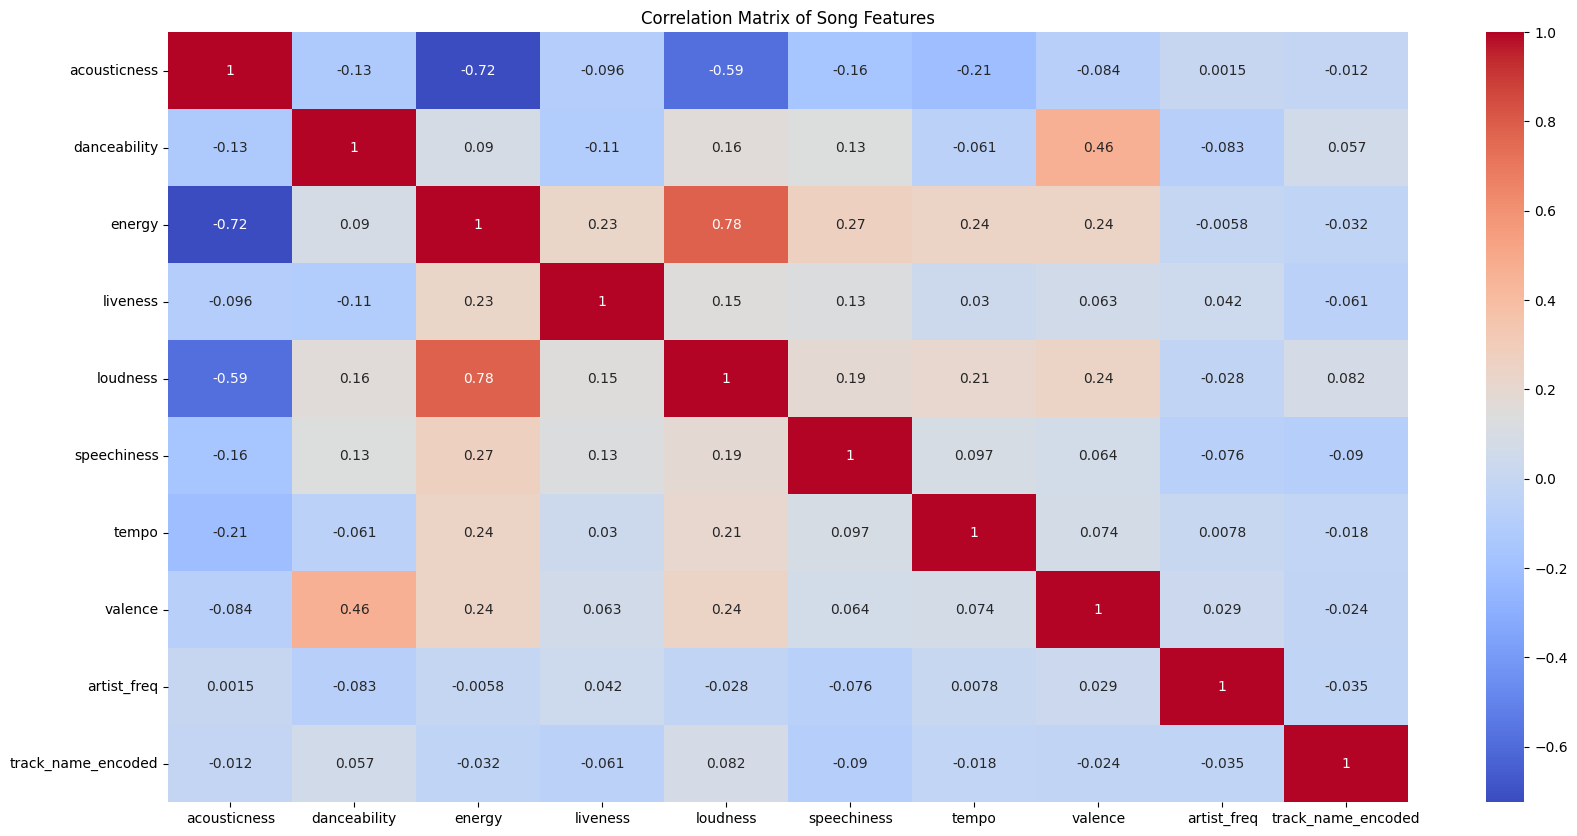

In [14]:

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['duration_min', 'danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'artist_freq', 'track_name_encoded']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Visualize correlation matrix
song_features = ['acousticness', 'danceability', 'energy', 'liveness',
                 'loudness', 'speechiness', 'tempo', 'valence', 'artist_freq', 'track_name_encoded']
plt.figure(figsize=(20, 10))
sns.heatmap(df[song_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Song Features')
plt.show()

In [15]:
# One-hot encode track_genre
genres = pd.get_dummies(df['track_genre'], prefix='genre')
df = pd.concat([df, genres], axis=1)
df = df.drop('track_genre', axis=1)

# Prepare features and target
X = df.drop('popularity', axis=1)
y = df['popularity']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
print("\nClass distribution after SMOTE:")
print(y.value_counts())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Class distribution after SMOTE:
popularity
Low          33067
Normal       33067
Medium       33067
High         33067
Very High    33067
Name: count, dtype: int64


In [16]:
df.shape

(97149, 131)

In [17]:

df.head()

,popularity,duration_min,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,genre_spanish,genre_study,genre_swedish,genre_synth-pop,genre_tango,genre_techno,genre_trance,genre_trip-hop,genre_turkish,genre_world-music
0,High,0.075023,0.0,0.642765,-0.738284,1.0,0.304670,0.0,1.730390,-0.844810,...,False,False,False,False,False,False,False,False,False,False
1,Medium,-1.001889,0.0,-0.847917,-1.916737,1.0,-2.319327,1.0,0.195098,1.859548,...,False,False,False,False,False,False,False,False,False,False
2,Medium,-0.188572,0.0,-0.743103,-1.145749,0.0,-0.442828,1.0,-0.279070,-0.305636,...,False,False,False,False,False,False,False,False,False,False
3,High,-0.306725,0.0,-1.744655,-2.341779,0.0,-2.409887,1.0,-0.725617,1.801931,...,False,False,False,False,False,False,False,False,False,False
4,Very High,-0.347646,0.0,0.305032,-0.810190,2.0,-0.429569,1.0,-0.350426,0.479774,...,False,False,False,False,False,False,False,False,False,False


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns


# --- RandomForestClassifier ---
print("\n=== RandomForestClassifier ===")
# Define hyperparameter search space for RandomForestClassifier
rf_param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
    'criterion': Categorical(['gini', 'entropy'])
}

# Train RandomForestClassifier with BayesSearchCV
rf_model = RandomForestClassifier(random_state=42)
rf_bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=rf_param_space,
    n_iter=32,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
rf_bayes_search.fit(X_train, y_train)

# Best RandomForest model
rf_best_model = rf_bayes_search.best_estimator_
print("\nBest parameters for RandomForestClassifier:", rf_bayes_search.best_params_)

# Predictions
rf_y_pred = rf_best_model.predict(X_test)
rf_y_pred_train = rf_best_model.predict(X_train)

# Evaluation
print("\nRandomForest Training Classification Report:")
print(classification_report(y_train, rf_y_pred_train))
print("\nRandomForest Testing Classification Report:")
print(classification_report(y_test, rf_y_pred))

# Confusion matrix
cm_rf = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('RandomForest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nRandomForest Feature Importance:")
print(rf_feature_importance.head(10))


# Single Tree
from sklearn.tree import plot_tree
y_numeric = y.map({'Low': 0, 'Normal': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], feature_names=X_train.columns, class_names=[str(int(i)) for i in sorted(y_numeric.unique())], filled=True)
plt.title("Tree 0 of Random Forest")
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Testing score')
plt.title('Learning Curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


=== RandomForestClassifier ===


# KNN (Optional)

In [ ]:
# # --- KNeighborsClassifier ---
# from sklearn.neighbors import KNeighborsClassifier
# print("\n=== KNeighborsClassifier ===")
# # Train KNeighborsClassifier with default parameters
# knn_model = KNeighborsClassifier()
# knn_model.fit(X_train, y_train)

# # Predictions
# knn_y_pred = knn_model.predict(X_test)
# knn_y_pred_train = knn_model.predict(X_train)

# # Evaluation
# print("\nKNN Training Classification Report:")
# print(classification_report(y_train, knn_y_pred_train))
# print("\nKNN Testing Classification Report:")
# print(classification_report(y_test, knn_y_pred))

# # Confusion matrix
# cm_knn = confusion_matrix(y_test, knn_y_pred)
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.title('KNN Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()